In [1]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from pandas.api.types import is_numeric_dtype

building_repo = BuildingRepository()
df = pd.DataFrame(building_repo.get_totalpower_col())
df = df.drop("_id", axis=1)
print(df)
df['datetime'] = pd.to_datetime(df['datetime'])

#df.set_index("datetime", inplace=True)
#df = df.resample('1H').mean()
#df["datetime"] = df.index

df['totalpower'] = pd.to_numeric(df['totalpower'], errors='coerce')
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute

df.rename(columns={'totalpower': 'Consumption'}, inplace=True)
df.drop(['datetime', 'totalgeneration'], axis=1, inplace=True)

df = df.dropna()
df['Consumption-1'] = df['Consumption'].shift(1)
df.loc[df['Day'] != df['Day'].shift(1), 'Consumption-1'] = 0
df['Consumption-2'] = df['Consumption'].shift(2)
df.loc[df['Day'] != df['Day'].shift(2), 'Consumption-2'] = 0
#df = df[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
df = df[['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption']]
df

       totalpower  totalgeneration                datetime
0          2185.6            664.5 2023-10-02 11:03:01.147
1          3438.0            664.5 2023-10-02 11:03:00.481
2          2165.8            659.0 2023-10-02 11:02:56.145
3          3388.0            656.5 2023-10-02 11:02:55.714
4          2130.6            653.5 2023-10-02 11:02:51.151
...           ...              ...                     ...
99995      3519.0           2007.0 2023-09-29 13:43:16.468
99996      2925.2           2007.0 2023-09-29 13:43:16.124
99997      3470.0           2010.5 2023-09-29 13:43:11.459
99998      2928.4           2012.0 2023-09-29 13:43:11.115
99999      3473.0           2006.0 2023-09-29 13:43:06.505

[100000 rows x 3 columns]


,Month,Day,Hour,Minute,Consumption-1,Consumption-2,Consumption
0,10,2,11,3,0.0,0.0,2185.6
1,10,2,11,3,2185.6,0.0,3438.0
2,10,2,11,2,3438.0,2185.6,2165.8
3,10,2,11,2,2165.8,3438.0,3388.0
4,10,2,11,2,3388.0,2165.8,2130.6
...,...,...,...,...,...,...,...
99995,9,29,13,43,2927.4,3583.0,3519.0
99996,9,29,13,43,3519.0,2927.4,2925.2
99997,9,29,13,43,2925.2,3519.0,3470.0
99998,9,29,13,43,3470.0,2925.2,2928.4


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Data preprocessing - Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
pred_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = pred_scaler.fit_transform(np.array(df['Consumption']).reshape(-1, 1))

# split into train and test sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]
print("Len train", len(train), "Len test", len(test))

Len train 80000 Len test 20000


In [3]:
import joblib

# Assuming you have a scaler object named 'scaler'
joblib.dump(scaler, 'training_1/scaler.pkl')
joblib.dump(pred_scaler, 'training_1/pred_scaler.pkl')

['training_1/pred_scaler.pkl']

In [4]:
import numpy as np

# Prepare data for LSTM (sequence-to-sequence)
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)


timesteps = 1
X_train, y_train = prepare_data(train, timesteps)
X_test, y_test = prepare_data(test, timesteps)

print("X_train shape", X_train.shape, "timesteps", timesteps)
print("X_test shape", X_test.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[2]))

print("X_train shape", X_train.shape, "y_train shape", y_train.shape)
print("X_test shape", X_test.shape, "y_test shape", y_test.shape)

X_train shape (79997, 1, 6) timesteps 1
X_test shape (19997, 1, 6) timesteps 1
X_train shape (79997, 1, 6) y_train shape (79997,)
X_test shape (19997, 1, 6) y_test shape (19997,)


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

def create_model():
    # LSTM model
    model = Sequential()
    print(timesteps, X_train.shape[2])
    model.add(LSTM(units=4, input_shape=(timesteps, X_train.shape[2])))
    model.add(Dense(units=1))  # Use the original number of features as the output units
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.metrics.Accuracy(), 'mae', 'mse'])

    return model

model = create_model()

# Display the model's architecture
model.summary()

1 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 176       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [6]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1, callbacks=[cp_callback])

79992/79997 [============================>.] - ETA: 0s - loss: 3.1043e-04 - accuracy: 0.0000e+00 - mae: 0.0076 - mse: 3.1043e-04
Epoch 1: saving model to training_1\cp.ckpt
79997/79997 [==============================] - 387s 5ms/step - loss: 3.1041e-04 - accuracy: 0.0000e+00 - mae: 0.0076 - mse: 3.1041e-04


In [7]:
y_test

array([0.13212307, 0.05107104, 0.13212307, ..., 0.53924407, 0.41646679,
       0.52911256])

In [8]:
# Evaluate the model
loss, acc, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%, mae: {:5.2f}%, mse: {:5.2f}%".format(100 * acc, mae, mse))

model.save('saved_model/consumption_forecast')

y_train_inv = pred_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = pred_scaler.inverse_transform(y_test.reshape(-1, 1))

# Make predictions on train and test sets
y_train_pred = model.predict(X_train)
y_train_pred = pred_scaler.inverse_transform(y_train_pred)

y_test_pred = model.predict(X_test)
y_test_pred = pred_scaler.inverse_transform(y_test_pred)

# Display the original DataFrame and the predicted values after inverse scaling for train and test sets
print("Original DataFrame:")
print("y_train_inv.shape", y_train_inv.shape, "y_train_pred.shape", y_train_pred.shape)

625/625 - 3s - loss: 4.3401e-04 - accuracy: 0.0000e+00 - mae: 0.0087 - mse: 4.3401e-04 - 3s/epoch - 5ms/step
Trained model, accuracy:  0.00%, mae:  0.01%, mse:  0.00%


INFO:tensorflow:Assets written to: saved_model/consumption_forecast\assets


INFO:tensorflow:Assets written to: saved_model/consumption_forecast\assets


625/625 [==============================] - 2s 3ms/step
Original DataFrame:
y_train_inv.shape (79997, 1) y_train_pred.shape (79997, 1)


In [9]:
model.save_weights('./checkpoints/my_checkpoint')

In [10]:
model_test = create_model()

loss, acc, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%, mae: {:5.2f}%, mse: {:5.2f}%".format(100 * acc, mae, mse))

1 6
625/625 - 3s - loss: 0.1116 - accuracy: 0.0000e+00 - mae: 0.2387 - mse: 0.1116 - 3s/epoch - 6ms/step
Trained model, accuracy:  0.00%, mae:  0.24%, mse:  0.11%


In [11]:
# Restore the weights
model_test.load_weights('./checkpoints/my_checkpoint')

# Re-evaluate the model
loss, acc, mae, mse = model_test.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%, mae: {:5.2f}%, mse: {:5.2f}%".format(100 * acc, mae, mse))

625/625 - 2s - loss: 4.3401e-04 - accuracy: 0.0000e+00 - mae: 0.0087 - mse: 4.3401e-04 - 2s/epoch - 3ms/step
Trained model, accuracy:  0.00%, mae:  0.01%, mse:  0.00%


In [12]:
new_model = tf.keras.models.load_model('saved_model/consumption_forecast')

# Check its architecture
new_model.summary()

# Evaluate the restored model
loss, acc, mae, mse = new_model.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%, mae: {:5.2f}%, mse: {:5.2f}%".format(100 * acc, mae, mse))

print("New Model Shape", new_model.predict(X_test).shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 176       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
625/625 - 4s - loss: 4.3401e-04 - accuracy: 0.0000e+00 - mae: 0.0087 - mse: 4.3401e-04 - 4s/epoch - 6ms/step
Trained model, accuracy:  0.00%, mae:  0.01%, mse:  0.00%
625/625 [==============================] - 3s 3ms/step
New Model Shape (19997, 1)


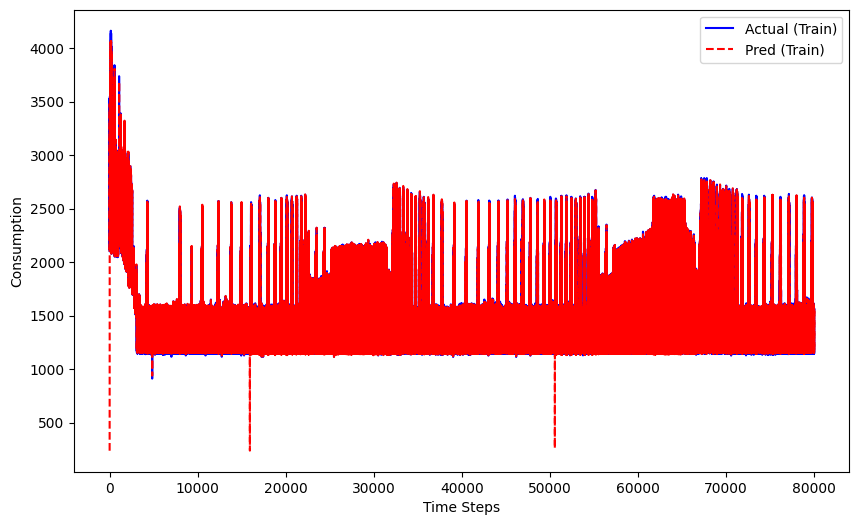

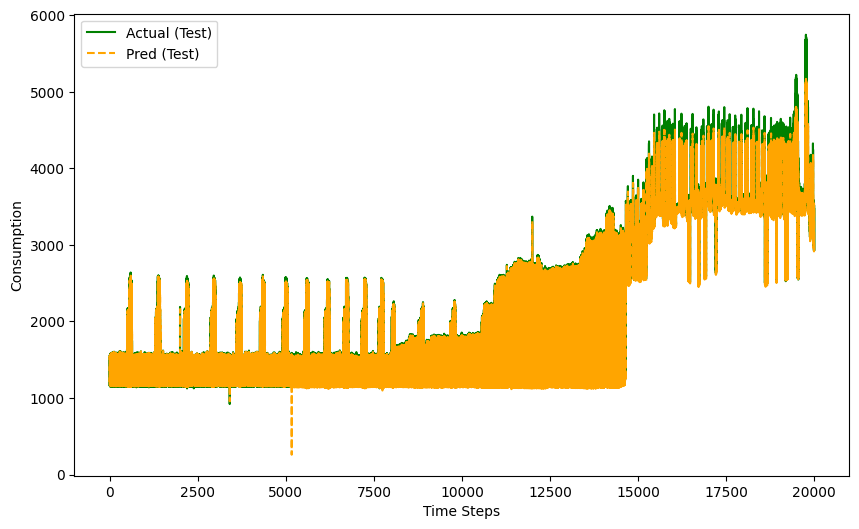

In [13]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_train_inv, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Pred (Train)', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))

plt.plot(y_test_inv, label='Actual (Test)', color='green')
plt.plot(y_test_pred, label='Pred (Test)', linestyle='dashed', color='orange')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


In [14]:
from datetime import timedelta
import pandas as pd
from database.BuildingRepository import BuildingRepository

building_repo = BuildingRepository()
df_test = pd.DataFrame(building_repo.get_totalpower_col())
df_test = df_test.drop("_id", axis=1)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
# Calculate the datetime for 24 hours ago from the current time
current_time = df_test['datetime'].max()
twenty_four_hours_ago = current_time - timedelta(hours=24)

# Filter the DataFrame to get only the rows for the last 24 hours
last_24_hours_data = df_test[df_test['datetime'] >= twenty_four_hours_ago]

last_24_hours_data['totalpower'] = pd.to_numeric(last_24_hours_data['totalpower'], errors='coerce')
last_24_hours_data['Month'] = last_24_hours_data['datetime'].dt.month
last_24_hours_data['Day'] = last_24_hours_data['datetime'].dt.day
last_24_hours_data['Hour'] = last_24_hours_data['datetime'].dt.hour
last_24_hours_data['Minute'] = last_24_hours_data['datetime'].dt.minute

last_24_hours_data.rename(columns={'totalpower': 'Consumption'}, inplace=True)
last_24_hours_data.drop(['datetime', 'totalgeneration'], axis=1, inplace=True)

last_24_hours_data = last_24_hours_data.dropna()
last_24_hours_data['Consumption-1'] = last_24_hours_data['Consumption'].shift(1)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(1), 'Consumption-1'] = 0
last_24_hours_data['Consumption-2'] = last_24_hours_data['Consumption'].shift(2)
last_24_hours_data.loc[last_24_hours_data['Day'] != last_24_hours_data['Day'].shift(2), 'Consumption-2'] = 0
#last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data = last_24_hours_data[['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption']]
last_24_hours_data

C:\Users\rdpds\AppData\Local\Temp\2\ipykernel_92672\645768180.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_24_hours_data['totalpower'] = pd.to_numeric(last_24_hours_data['totalpower'], errors='coerce')
C:\Users\rdpds\AppData\Local\Temp\2\ipykernel_92672\645768180.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_24_hours_data['Month'] = last_24_hours_data['datetime'].dt.month
C:\Users\rdpds\AppData\Local\Temp\2\ipykernel_92672\645768180.py:19: SettingWithCopyWarning: 
A value is trying 

,Month,Day,Hour,Minute,Consumption-1,Consumption-2,Consumption
0,10,2,11,10,0.0000,0.0000,2163.5998
1,10,2,11,10,2163.5998,0.0000,3384.0000
2,10,2,11,10,3384.0000,2163.5998,2106.6000
3,10,2,11,10,2106.6000,3384.0000,3428.0000
4,10,2,11,10,3428.0000,2106.6000,2107.8000
...,...,...,...,...,...,...,...
34598,10,1,11,10,1145.0000,1544.0000,1544.0000
34599,10,1,11,10,1544.0000,1145.0000,1169.0000
34600,10,1,11,10,1169.0000,1544.0000,1530.0000
34601,10,1,11,10,1530.0000,1169.0000,1167.0000


In [15]:
import joblib

# Load the scaler
scaler_test = joblib.load('training_1/scaler.pkl')
pred_scaler_test = joblib.load('training_1/pred_scaler.pkl')

df_scaled = scaler_test.fit_transform(last_24_hours_data)

print("Len pred", int(len(df_scaled)))

Len pred 34603


In [16]:
import numpy as np
timesteps = 1

def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:i + time_steps, :-1])  # Exclude the last column (Consumption)
        y.append(data[i + time_steps, -1])  # The last column (Consumption) is the target
    return np.array(X), np.array(y)

X_pred, y = prepare_data(df_scaled, timesteps)

print("X_pred shape", X_pred.shape, "timesteps", timesteps)

# reshape input to be [samples, time steps, features]
X_pred = np.reshape(X_pred, (X_pred.shape[0], timesteps, X_pred.shape[2]))

print("X_pred shape", X_pred.shape, "y_pred shape", y.shape)

X_pred shape (34600, 1, 6) timesteps 1
X_pred shape (34600, 1, 6) y_pred shape (34600,)


In [17]:
model

In [18]:
import tensorflow as tf

model = tf.keras.models.load_model('saved_model/consumption_forecast')
y_pred = model.predict(X_pred)
y_pred = pred_scaler_test.inverse_transform(y_pred)
y = pred_scaler_test.inverse_transform(y.reshape(-1, 1))

1082/1082 [==============================] - 5s 3ms/step


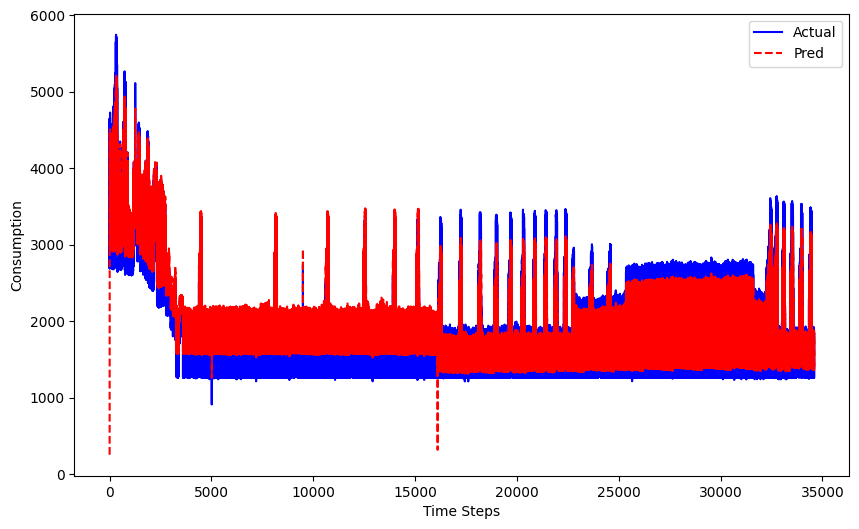

In [19]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_pred, label='Pred', linestyle='dashed', color='red')

plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()


In [20]:
last = scaler_test.inverse_transform(df_scaled[:-3])

df = pd.DataFrame(last, columns=['Month', 'Day', 'Hour', 'Minute', 'Consumption-1', 'Consumption-2', 'Consumption'])
df['Prediction'] = y_pred
df['datetime'] = pd.to_datetime(df[['Month', 'Day', 'Hour', 'Minute']].assign(Year=2023))

# Drop the separate columns if needed
df.drop(['Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

df.set_index("datetime", inplace=True)
df = df.resample('1H').mean()
df["datetime"] = df.index
# Now, 'datetime' contains the combined datetime values
df

,Consumption-1,Consumption-2,Consumption,Prediction,datetime
datetime,,,,,
2023-10-01 11:00:00,1506.543147,1506.565144,1506.553299,1805.206055,2023-10-01 11:00:00
2023-10-01 12:00:00,1545.008270,1544.731909,1544.544452,1847.703003,2023-10-01 12:00:00
2023-10-01 13:00:00,1610.409028,1610.409722,1610.228472,1926.677490,2023-10-01 13:00:00
2023-10-01 14:00:00,1638.111111,1638.093750,1638.104167,1957.400513,2023-10-01 14:00:00
2023-10-01 15:00:00,1638.277778,1638.295139,1638.277778,1953.112671,2023-10-01 15:00:00
2023-10-01 16:00:00,1635.516667,1635.514583,1635.509722,1945.292480,2023-10-01 16:00:00
2023-10-01 17:00:00,1571.798209,1571.789945,1572.002066,1860.354736,2023-10-01 17:00:00
2023-10-01 18:00:00,1524.529861,1524.529861,1524.539583,1796.238892,2023-10-01 18:00:00
2023-10-01 19:00:00,1488.686111,1488.695139,1488.422222,1748.167725,2023-10-01 19:00:00


In [9]:
from datetime import datetime, timedelta
import pandas as pd
from database.BuildingRepository import BuildingRepository

building_repo = BuildingRepository()
now = datetime.now()
start = now - timedelta(days=7, hours=now.hour, minutes=now.minute)
consumption = building_repo.get_historic_interval(start, start + timedelta(days=1))
consumption = pd.DataFrame(consumption)
total = consumption.drop(["_id"], axis=1)

total = total.dropna()

total = total.values.tolist()
total_power = []

for row in total:
    iots = row[0]
    date = row[1]
    consumption = 0
    for iot in iots:
        for value in iot['values']:
            if 'values' in value:
                if value['type'] == 'power':
                    consumption += value['values']

    total_power.append([date, consumption])
    
total = pd.DataFrame(total_power, columns=['datetime', 'consumption'])
total['datetime'] = pd.to_datetime(total['datetime'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)
total.set_index("datetime", inplace=True)
total = total.resample('1H').mean()
total = total.tail(24)
total['datetime'] = total.index
return total['consumption'].values.tolist()

[184.18055555555554,
 164.34722222222223,
 157.51388888888889,
 113.61760660247593,
 102.45833333333333,
 101.61111111111111,
 107.02777777777777,
 104.29752066115702,
 102.19444444444444,
 103.29166666666667,
 114.79166666666667,
 199.9862258953168,
 452.69444444444446,
 232.47222222222223,
 145.25352112676057,
 209.8546511627907,
 231.49171270718233,
 368.3611111111111,
 279.55555555555554,
 219.73611111111111,
 295.8126721763085,
 216.40277777777777,
 206.44444444444446,
 220.0]